# 15. Unsupervised Machine Learning: K-means clustering with Songs

Context: I explored the relationship between the total spotify plays and count of chart weeks, with a correlation coefficient of .643. However, regression analysis did not prove that a linear model was a good fit (MSE 62.92 and R2 score 0.465). Removing songs that never made top charts did not solve poor fit scores, as there remained too many outliers without normal distribution. This means that I was unable to reject my null hypothesis ("As song's total number of Billboard Hot 100 chart weeks increases, the song's total spotify streams will also increase.")

My main goal is to see if I can identify song clusters that are not grouped solely by album. Grouping by album presents a certain amount of over-simplicity, as well as bias since I listen to Taylor Swift's music.

Another goal is to try to identify if there are any sound characteristics that overlap with chart or stream success. So far, speechiness has the strongest relationship. It has been unexpected that sound characteristics have not had more of an impact.

Previously, I have completed clustering analysis for albums based on album measures and state search scores. 

Here, I want to explore clusters for songs, since it's a finer grain with more variables to consider.

# Contents 


*Note: Used the PCA technique to standardize and reduce dimensionality, then combine those results with K-means clustering 


# 01. Import libraries and data   

# 02. Review and clean dataframe
- Basic cleaning
- Visualize relationships of focus


# 03. Data preprocessing
- Numerical df
- Standardization
- Reduce dimensionality
- PCA explained features
- Perform Principal Components Analysis (PCA)

# 04. Incorporate PCA with K-means
- Elbow technique
- Implement K-means

# 05. Analyze results
- Visualize K-means results
- Plot clusters with variables
- Compare cluster stats

# 06. Update song clusters on relevant dfs

# 07. Key observations and next steps


# 08. Data export

### Goal: Given the lack of linear correlations within variables, especially success metrix, want to examine if clustering reveals patterns using groups of songs that are not just based on album

#### Variables of focus: 
"Song Days Since Release vs. Total Spotify Streams" -0.04 corr coeff
"Song Speechiness vs. Total Spotify Streams" 0.054 corr coeff
"Count Chart Weeks vs. Total Spotify Streams" 0.643 corr coeff

##### Success Metrics: total streams and count of chart weeks
- total song streams as tot_streams 
- Hot 100 chart weeks as cnt_chart_wks
- Average daily streams as streams_n

#### Variables of songs to explore
- track (initially, but is categorical)
- days since release
- speechiness

##### Curious to explore visually through clusters (not continuous variables)
- album number
- Taylor's Version
- track (techinically categorical)
- clusters across albums to identify stand out songs within albums

# Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
import pylab as pl 
import warnings

In [2]:
# Display viz in cells

%matplotlib inline

In [3]:
# Filter out future warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Define path

path = r"C:\Users\leobs\OneDrive\Desktop\LF_TS_Analysis"

In [5]:
# Import songs dataframe that contains all song information
# Includnig recent updats to count of billboard songs

df = pd.read_csv(os.path.join(path,'02 Manipulated Data', 'song_stream_alb_final_4.csv'), index_col = 0)

In [6]:
# Import billboard dataframe for update at end
bill = pd.read_csv(os.path.join(path,'02 Manipulated Data', 'df_hot_100_ts_only_dec_23.csv'), index_col = 0)

In [7]:
df.shape

(282, 45)

In [8]:
df.head()

,song_title,album_title,song_release_date,track,acou,dance,ener,instru,live,loud,...,top_alb_count,top_alb_normal,alb_track_cnt,tvflag,sales_group,tot_streams_group,alb_genre,cluster,cnt_chart_wks,_merge
0,Welcome To New York (Taylor's Version),1989 (Taylor's Version)[Deluxe],10/27/2023,1,0.009420,0.757,0.610,0.000037,0.3670,-4.840,...,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,2.0,both
1,Blank Space (Taylor's Version),1989 (Taylor's Version)[Deluxe],10/27/2023,2,0.088500,0.733,0.733,0.000000,0.1680,-5.376,...,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,3.0,both
2,Style (Taylor's Version),1989 (Taylor's Version)[Deluxe],10/27/2023,3,0.000421,0.511,0.822,0.019700,0.0899,-4.785,...,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,4.0,both
3,Out Of The Woods (Taylor's Version),1989 (Taylor's Version)[Deluxe],10/27/2023,4,0.000537,0.545,0.885,0.000056,0.3850,-5.968,...,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,3.0,both
4,All You Had To Do Was Stay (Taylor's Version),1989 (Taylor's Version)[Deluxe],10/27/2023,5,0.000656,0.588,0.721,0.000000,0.1310,-5.579,...,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,2.0,both


In [9]:
bill.shape

(1446, 49)

# 02. Review and clean dataframe
- Basic cleaning
- Visualize relationships of focus

In [10]:
df.head()

,song_title,album_title,song_release_date,track,acou,dance,ener,instru,live,loud,...,top_alb_count,top_alb_normal,alb_track_cnt,tvflag,sales_group,tot_streams_group,alb_genre,cluster,cnt_chart_wks,_merge
0,Welcome To New York (Taylor's Version),1989 (Taylor's Version)[Deluxe],10/27/2023,1,0.009420,0.757,0.610,0.000037,0.3670,-4.840,...,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,2.0,both
1,Blank Space (Taylor's Version),1989 (Taylor's Version)[Deluxe],10/27/2023,2,0.088500,0.733,0.733,0.000000,0.1680,-5.376,...,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,3.0,both
2,Style (Taylor's Version),1989 (Taylor's Version)[Deluxe],10/27/2023,3,0.000421,0.511,0.822,0.019700,0.0899,-4.785,...,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,4.0,both
3,Out Of The Woods (Taylor's Version),1989 (Taylor's Version)[Deluxe],10/27/2023,4,0.000537,0.545,0.885,0.000056,0.3850,-5.968,...,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,3.0,both
4,All You Had To Do Was Stay (Taylor's Version),1989 (Taylor's Version)[Deluxe],10/27/2023,5,0.000656,0.588,0.721,0.000000,0.1310,-5.579,...,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,2.0,both


In [11]:
df.columns

Index(['song_title', 'album_title', 'song_release_date', 'track', 'acou',
       'dance', 'ener', 'instru', 'live', 'loud', 'speech', 'temp', 'val',
       'pop', 'dur', 'album_id', 'song_id', 'days', 'tot_streams',
       'last_stream_update', 'streams_n', 'top_song', 'top_song_flag',
       'top_s_cnt', 'tv', 'alb_num', 'album_announce_mo', 'alb_ann_day',
       'alb_ann_yr', 'album_announce_date', 'album_release_mo', 'alb_r_day',
       'alb_r_yr', 'album_release_date', 'w1_sales', 'top_alb_count',
       'top_alb_normal', 'alb_track_cnt', 'tvflag', 'sales_group',
       'tot_streams_group', 'alb_genre', 'cluster', 'cnt_chart_wks', '_merge'],
      dtype='object')

In [12]:
# Rename cluster column to be "album_cluster"

df.rename(columns = {'cluster': 'alb_cluster_num'}, inplace=True)

In [13]:
# Drop merge flag

df.drop(columns = ['_merge'], axis=1, inplace=True)

In [14]:
df.columns

Index(['song_title', 'album_title', 'song_release_date', 'track', 'acou',
       'dance', 'ener', 'instru', 'live', 'loud', 'speech', 'temp', 'val',
       'pop', 'dur', 'album_id', 'song_id', 'days', 'tot_streams',
       'last_stream_update', 'streams_n', 'top_song', 'top_song_flag',
       'top_s_cnt', 'tv', 'alb_num', 'album_announce_mo', 'alb_ann_day',
       'alb_ann_yr', 'album_announce_date', 'album_release_mo', 'alb_r_day',
       'alb_r_yr', 'album_release_date', 'w1_sales', 'top_alb_count',
       'top_alb_normal', 'alb_track_cnt', 'tvflag', 'sales_group',
       'tot_streams_group', 'alb_genre', 'alb_cluster_num', 'cnt_chart_wks'],
      dtype='object')

In [15]:
bill.columns

Index(['chart_week', 'chart_position', 'song_title', 'artist',
       'prior_wk_position', 'peak_pos', 'wks_on_chart', 'album_title',
       'song_release_date', 'track', 'acou', 'dance', 'ener', 'instru', 'live',
       'loud', 'speech', 'temp', 'val', 'pop', 'dur', 'album_id', 'song_id',
       'days', 'tot_streams', 'last_stream_update', 'streams_n', 'top_song',
       'top_song_flag', 'top_s_cnt', 'tv', 'alb_num', 'album_announce_mo',
       'alb_ann_day', 'alb_ann_yr', 'album_announce_date', 'album_release_mo',
       'alb_r_day', 'alb_r_yr', 'album_release_date', 'w1_sales',
       'top_alb_count', 'top_alb_normal', 'alb_track_cnt', 'tvflag',
       'sales_group', 'tot_streams_group', 'alb_genre', '_merge'],
      dtype='object')

In [16]:
bill.shape

(1446, 49)

In [17]:
bill.head(50)

,chart_week,chart_position,song_title,artist,prior_wk_position,peak_pos,wks_on_chart,album_title,song_release_date,track,...,album_release_date,w1_sales,top_alb_count,top_alb_normal,alb_track_cnt,tvflag,sales_group,tot_streams_group,alb_genre,_merge
884.0,7/27/2013,65.0,22,Taylor Swift,55.0,20.0,20.0,Red (Deluxe Edition),10/22/2012,6.0,...,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,both
885.0,7/20/2013,55.0,22,Taylor Swift,49.0,20.0,19.0,Red (Deluxe Edition),10/22/2012,6.0,...,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,both
886.0,7/13/2013,49.0,22,Taylor Swift,41.0,20.0,18.0,Red (Deluxe Edition),10/22/2012,6.0,...,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,both
887.0,7/6/2013,41.0,22,Taylor Swift,32.0,20.0,17.0,Red (Deluxe Edition),10/22/2012,6.0,...,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,both
889.0,6/29/2013,32.0,22,Taylor Swift,26.0,20.0,16.0,Red (Deluxe Edition),10/22/2012,6.0,...,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,both
893.0,6/22/2013,26.0,22,Taylor Swift,24.0,20.0,15.0,Red (Deluxe Edition),10/22/2012,6.0,...,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,both
896.0,6/15/2013,24.0,22,Taylor Swift,23.0,20.0,14.0,Red (Deluxe Edition),10/22/2012,6.0,...,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,both
898.0,6/8/2013,23.0,22,Taylor Swift,26.0,20.0,13.0,Red (Deluxe Edition),10/22/2012,6.0,...,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,both
900.0,6/1/2013,26.0,22,Taylor Swift,25.0,20.0,12.0,Red (Deluxe Edition),10/22/2012,6.0,...,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,both
902.0,5/25/2013,25.0,22,Taylor Swift,21.0,20.0,11.0,Red (Deluxe Edition),10/22/2012,6.0,...,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,both


In [18]:
bill.tail(50)

,chart_week,chart_position,song_title,artist,prior_wk_position,peak_pos,wks_on_chart,album_title,song_release_date,track,...,album_release_date,w1_sales,top_alb_count,top_alb_normal,alb_track_cnt,tvflag,sales_group,tot_streams_group,alb_genre,_merge
1201.0,8/29/2009,4.0,You Belong With Me,Taylor Swift,2.0,2.0,17.0,Fearless Platinum Edition,11/11/2008,12.0,...,11/11/2008,592300.0,261.0,0.047663,19.0,False,Medium first week sales,High total streams,Country pop,both
1203.0,8/22/2009,2.0,You Belong With Me,Taylor Swift,3.0,2.0,16.0,Fearless Platinum Edition,11/11/2008,12.0,...,11/11/2008,592300.0,261.0,0.047663,19.0,False,Medium first week sales,High total streams,Country pop,both
1205.0,8/15/2009,3.0,You Belong With Me,Taylor Swift,4.0,3.0,15.0,Fearless Platinum Edition,11/11/2008,12.0,...,11/11/2008,592300.0,261.0,0.047663,19.0,False,Medium first week sales,High total streams,Country pop,both
1207.0,8/8/2009,4.0,You Belong With Me,Taylor Swift,3.0,3.0,14.0,Fearless Platinum Edition,11/11/2008,12.0,...,11/11/2008,592300.0,261.0,0.047663,19.0,False,Medium first week sales,High total streams,Country pop,both
1209.0,8/1/2009,3.0,You Belong With Me,Taylor Swift,6.0,3.0,13.0,Fearless Platinum Edition,11/11/2008,12.0,...,11/11/2008,592300.0,261.0,0.047663,19.0,False,Medium first week sales,High total streams,Country pop,both
1211.0,7/25/2009,6.0,You Belong With Me,Taylor Swift,9.0,6.0,12.0,Fearless Platinum Edition,11/11/2008,12.0,...,11/11/2008,592300.0,261.0,0.047663,19.0,False,Medium first week sales,High total streams,Country pop,both
1213.0,7/18/2009,9.0,You Belong With Me,Taylor Swift,11.0,9.0,11.0,Fearless Platinum Edition,11/11/2008,12.0,...,11/11/2008,592300.0,261.0,0.047663,19.0,False,Medium first week sales,High total streams,Country pop,both
1215.0,7/11/2009,11.0,You Belong With Me,Taylor Swift,16.0,11.0,10.0,Fearless Platinum Edition,11/11/2008,12.0,...,11/11/2008,592300.0,261.0,0.047663,19.0,False,Medium first week sales,High total streams,Country pop,both
1217.0,7/4/2009,16.0,You Belong With Me,Taylor Swift,18.0,12.0,9.0,Fearless Platinum Edition,11/11/2008,12.0,...,11/11/2008,592300.0,261.0,0.047663,19.0,False,Medium first week sales,High total streams,Country pop,both
1219.0,6/27/2009,18.0,You Belong With Me,Taylor Swift,32.0,12.0,8.0,Fearless Platinum Edition,11/11/2008,12.0,...,11/11/2008,592300.0,261.0,0.047663,19.0,False,Medium first week sales,High total streams,Country pop,both


In [19]:
bill.isnull().sum()

chart_week             0
chart_position         0
song_title             0
artist                 0
prior_wk_position      0
peak_pos               0
wks_on_chart           0
album_title            0
song_release_date      0
track                  0
acou                   0
dance                  0
ener                   0
instru                 0
live                   0
loud                   0
speech                 0
temp                   0
val                    0
pop                    0
dur                    0
album_id               0
song_id                0
days                   0
tot_streams            0
last_stream_update     0
streams_n              0
top_song               0
top_song_flag          0
top_s_cnt              0
tv                     0
alb_num                0
album_announce_mo      0
alb_ann_day            0
alb_ann_yr             0
album_announce_date    0
album_release_mo       0
alb_r_day              0
alb_r_yr               0
album_release_date     0


### Visualize key variables

<Figure size 1200x900 with 0 Axes>

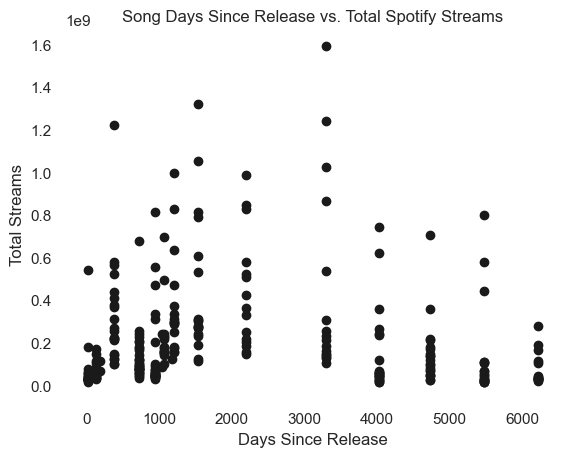

In [20]:
# "Song Days Since Release vs. Total Spotify Streams"
plt.figure(figsize = (12, 9))


tot_streams_days_scatt = df.plot(x = 'days', y='tot_streams',color = 'k', style='o') 

tot_streams_days_scatt.grid(False)
tot_streams_days_scatt.set_facecolor('#FFFFFF')

plt.title("Song Days Since Release vs. Total Spotify Streams")  
plt.xlabel("Days Since Release")  
plt.ylabel("Total Streams")  
tot_streams_days_scatt.get_legend().remove()

plt.show()

<Figure size 1200x900 with 0 Axes>

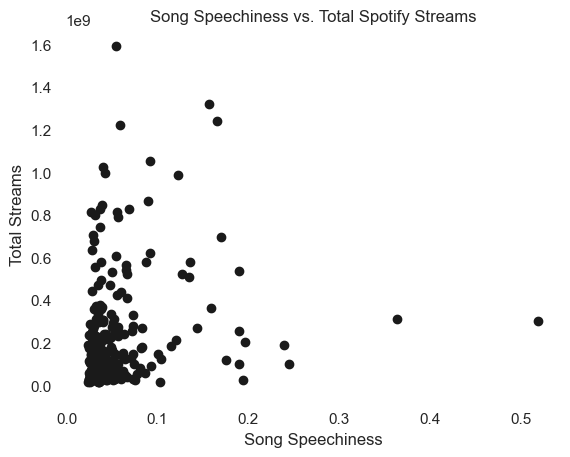

In [21]:
# "Song Speechiness vs. Total Spotify Streams"

plt.figure(figsize = (12, 9))


tot_streams_speech_scatt = df.plot(x = 'speech', y='tot_streams',color = 'k', style='o') 

tot_streams_speech_scatt.grid(False)
tot_streams_speech_scatt.set_facecolor('#FFFFFF')

plt.title("Song Speechiness vs. Total Spotify Streams")  
plt.xlabel("Song Speechiness")  
plt.ylabel("Total Streams")  
tot_streams_speech_scatt.get_legend().remove()

plt.show()

<Figure size 1200x900 with 0 Axes>

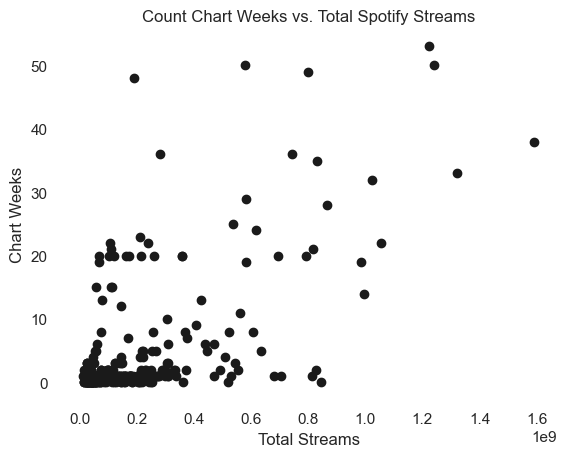

In [22]:
# "Count Chart Weeks vs. Total Spotify Streams"

plt.figure(figsize = (12, 9))


tot_streams_cnt_chart_wks_scatt = df.plot(x = 'tot_streams', y='cnt_chart_wks',color = 'k', style='o') 

tot_streams_cnt_chart_wks_scatt.grid(False)
tot_streams_cnt_chart_wks_scatt.set_facecolor('#FFFFFF')

plt.title("Count Chart Weeks vs. Total Spotify Streams")  
plt.xlabel("Total Streams")  
plt.ylabel("Chart Weeks")  
tot_streams_cnt_chart_wks_scatt.get_legend().remove()

plt.show()

# 03. Data preprocessing
- Numerical df: focus on relevant values (since songs focus)
- Standardization
- Reduce dimensionality
- PCA explained features
- Perform Principal Components Analysis (PCA)

In [23]:
df.columns

Index(['song_title', 'album_title', 'song_release_date', 'track', 'acou',
       'dance', 'ener', 'instru', 'live', 'loud', 'speech', 'temp', 'val',
       'pop', 'dur', 'album_id', 'song_id', 'days', 'tot_streams',
       'last_stream_update', 'streams_n', 'top_song', 'top_song_flag',
       'top_s_cnt', 'tv', 'alb_num', 'album_announce_mo', 'alb_ann_day',
       'alb_ann_yr', 'album_announce_date', 'album_release_mo', 'alb_r_day',
       'alb_r_yr', 'album_release_date', 'w1_sales', 'top_alb_count',
       'top_alb_normal', 'alb_track_cnt', 'tvflag', 'sales_group',
       'tot_streams_group', 'alb_genre', 'alb_cluster_num', 'cnt_chart_wks'],
      dtype='object')

In [24]:
# Change the order of the columns, 
# making sure that success measures are earlier on in df

df_2 = df[['song_id', 'cnt_chart_wks', 'tot_streams', 'streams_n', 
           'speech','days', 'song_title', 'song_release_date', 'track', 
           'acou', 'dance', 'ener', 'instru', 'live', 'loud', 
           'temp', 'val', 'pop', 'dur', 
           'top_song', 'top_song_flag', 'album_id', 
           'album_title', 'w1_sales', 
            'last_stream_update', 'top_s_cnt', 
            'tv', 'alb_num', 'album_announce_mo', 'alb_ann_day',
            'alb_ann_yr', 'album_announce_date', 'album_release_mo', 
             'alb_r_day', 'alb_r_yr', 'album_release_date', 'top_alb_count',
             'top_alb_normal', 'alb_track_cnt', 'tvflag', 'sales_group',
             'tot_streams_group', 'alb_genre', 'alb_cluster_num']]

In [25]:
df_2.head()

,song_id,cnt_chart_wks,tot_streams,streams_n,speech,days,song_title,song_release_date,track,acou,...,alb_r_yr,album_release_date,top_alb_count,top_alb_normal,alb_track_cnt,tvflag,sales_group,tot_streams_group,alb_genre,alb_cluster_num
0,1989TV01,2.0,35521714,2732439,0.0327,13,Welcome To New York (Taylor's Version),10/27/2023,1,0.009420,...,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2
1,1989TV02,3.0,40958068,3150620,0.0670,13,Blank Space (Taylor's Version),10/27/2023,2,0.088500,...,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2
2,1989TV03,4.0,47687102,3668238,0.0397,13,Style (Taylor's Version),10/27/2023,3,0.000421,...,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2
3,1989TV04,3.0,37545128,2888086,0.0447,13,Out Of The Woods (Taylor's Version),10/27/2023,4,0.000537,...,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2
4,1989TV05,2.0,31008534,2385271,0.0317,13,All You Had To Do Was Stay (Taylor's Version),10/27/2023,5,0.000656,...,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2


In [26]:
df_2.shape

(282, 44)

In [27]:
df_num = df_2.select_dtypes(include='number')

In [28]:
df_num.shape

(282, 27)

In [29]:
df_num.columns

Index(['cnt_chart_wks', 'tot_streams', 'streams_n', 'speech', 'days', 'track',
       'acou', 'dance', 'ener', 'instru', 'live', 'loud', 'temp', 'val', 'pop',
       'dur', 'w1_sales', 'top_s_cnt', 'alb_num', 'alb_ann_day', 'alb_ann_yr',
       'alb_r_day', 'alb_r_yr', 'top_alb_count', 'top_alb_normal',
       'alb_track_cnt', 'alb_cluster_num'],
      dtype='object')

In [30]:
pd.set_option('display.max_columns', None)

In [31]:
df_num.corr()

,cnt_chart_wks,tot_streams,streams_n,speech,days,track,acou,dance,ener,instru,live,loud,temp,val,pop,dur,w1_sales,top_s_cnt,alb_num,alb_ann_day,alb_ann_yr,alb_r_day,alb_r_yr,top_alb_count,top_alb_normal,alb_track_cnt,alb_cluster_num
cnt_chart_wks,1.000000,0.633782,0.003431,0.099781,0.238926,-0.271468,-0.143979,0.128197,0.128398,-0.024148,0.072189,0.124684,-0.113621,0.099441,-0.030917,-0.174153,0.162548,-0.104937,-0.234071,0.140633,-0.242298,0.118421,-0.242298,0.250787,-0.111192,-0.173059,0.341596
tot_streams,0.633782,1.000000,0.083448,0.215645,-0.035367,-0.337803,-0.015810,0.104574,0.018235,-0.003820,-0.049043,-0.045229,-0.103937,0.078792,0.269653,-0.173958,0.162695,-0.112704,-0.082995,0.298543,0.034265,0.044071,0.034265,0.281858,0.232911,-0.223214,0.281852
streams_n,0.003431,0.083448,1.000000,0.025119,-0.203304,-0.021839,-0.076055,0.019387,0.033786,-0.007770,-0.028156,-0.038052,0.014623,-0.016893,0.160260,-0.066815,0.212401,0.152330,0.265808,-0.090120,0.199291,0.201693,0.199291,-0.246258,-0.053427,0.038614,-0.066327
speech,0.099781,0.215645,0.025119,1.000000,-0.160798,-0.092170,-0.016723,0.186061,-0.005025,-0.023260,0.018455,-0.166940,0.061995,0.088557,0.213795,-0.320372,0.189089,0.026112,0.102428,0.208683,0.156355,0.060971,0.156355,0.035479,0.202359,-0.115292,-0.033441
days,0.238926,-0.035367,-0.203304,-0.160798,1.000000,-0.157440,-0.138270,-0.016748,0.128114,-0.066482,0.068917,0.302833,0.006204,0.061751,-0.734327,0.011674,0.021924,-0.530204,-0.960659,-0.043756,-0.999415,0.218723,-0.999415,0.696312,-0.746277,-0.455090,0.545441
track,-0.271468,-0.337803,-0.021839,-0.092170,-0.157440,1.000000,0.147616,-0.047774,-0.084418,-0.039022,-0.038347,-0.155856,0.061531,-0.068630,-0.066587,0.133449,-0.066853,0.185800,0.185197,-0.036482,0.156838,-0.088649,0.156838,-0.202018,0.107049,0.332307,-0.205072
acou,-0.143979,-0.015810,-0.076055,-0.016723,-0.138270,0.147616,1.000000,-0.131544,-0.687439,0.161920,-0.146815,-0.704229,-0.086117,-0.182357,0.006170,0.062237,-0.192409,0.044446,0.047385,0.130118,0.135690,0.045087,0.135690,-0.038438,0.247354,-0.209704,-0.546058
dance,0.128197,0.104574,0.019387,0.186061,-0.016748,-0.047774,-0.131544,1.000000,0.045216,-0.069055,-0.024438,-0.018190,-0.272743,0.317407,0.050633,-0.283305,0.280822,-0.004865,-0.004593,0.127094,0.012925,0.114610,0.012925,0.068272,0.011456,-0.032089,0.215271
ener,0.128398,0.018235,0.033786,-0.005025,0.128114,-0.084418,-0.687439,0.045216,1.000000,-0.074898,0.185371,0.774971,0.138777,0.480580,0.029851,-0.151177,0.037188,-0.100091,-0.064627,-0.240739,-0.125063,-0.058007,-0.125063,0.074731,-0.181347,0.059907,0.431829
instru,-0.024148,-0.003820,-0.007770,-0.023260,-0.066482,-0.039022,0.161920,-0.069055,-0.074898,1.000000,-0.039847,-0.194235,-0.005072,-0.055338,-0.000347,-0.033421,-0.009710,0.036231,0.059169,0.055009,0.063127,-0.004943,0.063127,-0.049648,0.066684,-0.029599,-0.137087


##### As shown above, the strongest relationship with count of chart weeks is total streams, with a 0.635 corr coeff. Both measures have a weak relationship with wk1 album sales.

- At this grain- of song (vs. album aggregates), speechiness has almost no relationship to streams and chart weeks. 

- The strongest relationship to chart weeks is track (-0.275)

- The strongest relationship to total streams is also track (-0.343).

It is also important that daily streams (streams normalized) only has a -0.20 correlation coefficient with the days since release. The weak relationship shows that time is not the main factor in average daily streams. This is key to show which songs excel across time.

## Data standardization

In [32]:
# Standardize the data in order to give all variables equal weight

scaler = StandardScaler()
df_std = scaler.fit_transform(df_num)

In [33]:
df_std.shape

(282, 27)

## Dimensionality reduction

In [34]:
# Fit standardized data using PCA

pca= PCA()
pca.fit(df_std)

PCA()

## Make Feature decision: PCA explained

In [35]:
# Shows how much variance is explained by each of the components
# This is updated based on re-ordering the columns to help with focus

pca.explained_variance_ratio_

array([2.57825194e-01, 1.13750245e-01, 1.09549508e-01, 7.11742921e-02,
       5.17203186e-02, 4.70267057e-02, 4.43729212e-02, 3.80447878e-02,
       3.65046292e-02, 3.36012823e-02, 2.95391855e-02, 2.66117032e-02,
       2.53601717e-02, 2.21437626e-02, 1.83003652e-02, 1.56301825e-02,
       1.34264681e-02, 1.14924238e-02, 9.13298338e-03, 8.41428760e-03,
       5.13527862e-03, 4.66311725e-03, 4.19551962e-03, 1.70218687e-03,
       6.70070844e-04, 1.24097810e-05, 1.15481078e-33])

In [36]:
# Check shape, should match number of columns

pca.explained_variance_ratio_.shape

(27,)

Text(0, 0.5, 'Cumulative Explained Variance')

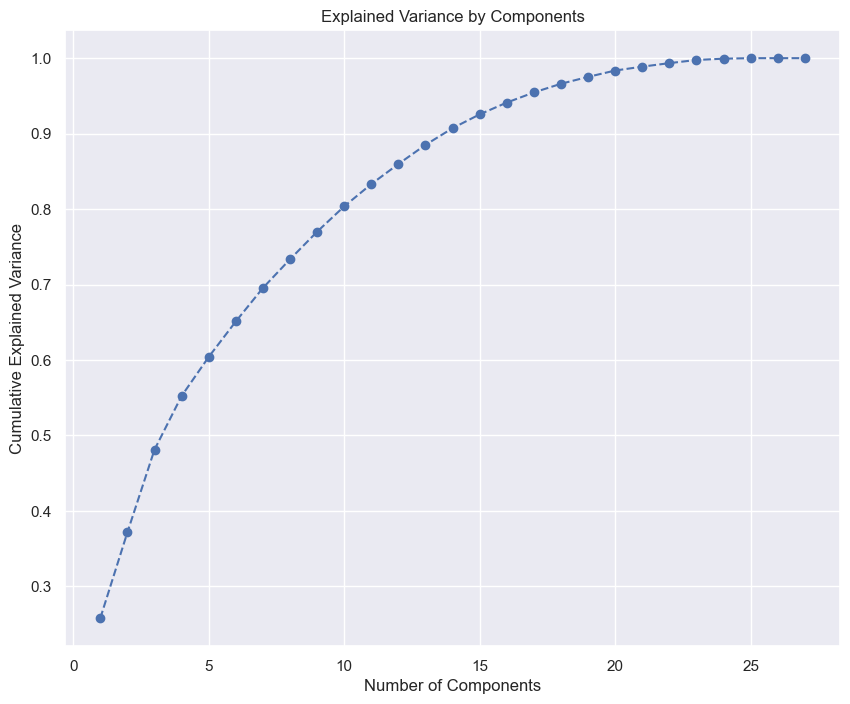

In [37]:
# Create a cumulative variance plot
# Will show how many variables explain what percentage of variance

plt.figure(figsize = (10,8))
plt.plot(range(1,28), pca.explained_variance_ratio_.cumsum(), marker= 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

Observations: The goal is to account for 80% of variance. 

Therefore, I am choosing to keep 10 out of 27 components.

## Perform PCA with chosen number of components

In [38]:
# Choosing to keep 10 components at this point based on the 80% metric

pca = PCA(n_components = 10)

In [39]:
# Fit the model on the data with the selected number of componenents

pca.fit(df_std)

PCA(n_components=10)

In [40]:
# Calculate resulting components scores for elements in data set

pca.transform(df_std)

array([[-1.67353395, -2.70244292,  0.81678016, ...,  1.65097251,
        -2.16385843, -0.4309024 ],
       [-1.81883941, -2.48008602,  0.94366903, ...,  0.42342431,
        -1.37201158,  0.15047973],
       [-1.94397227, -2.02474346,  0.11556735, ...,  0.62774758,
        -0.68696085,  0.93735981],
       ...,
       [ 4.43591997,  2.63178742, -0.90039776, ...,  0.26929869,
        -1.3764591 , -0.29983288],
       [ 4.80806865,  0.72104183, -1.42625099, ..., -0.19547678,
         0.05706105, -0.04713368],
       [ 4.93956354,  0.07878226, -1.22452415, ..., -0.55138153,
         1.06310122, -0.46762312]])

In [41]:
scores_pca = pca.transform(df_std)

Will incorporate new PCA scores into the K-means algorithm to perform segmentation based on principal components scores instead of original features.

# 04. Incorporate PCA with K-means
- Elbow technique
- Implement K-means

## The Elbow technique

### Decide the number of clusters

In [42]:
# Fit the k means using the transformed data from PCA
# Determine the within cluster sum of squares (WCSS) for each solution
# using algorithm with a different number of clusters
# Choosing between 1 and 10 clusters

wcss = []

for i in range (1, 11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

C:\Users\leobs\anaconda3\envs\Leoenvironment\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\leobs\anaconda3\envs\Leoenvironment\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\leobs\anaconda3\envs\Leoenvironment\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\leobs\anaconda3\envs\Leoenvironment\lib\site-packages\sklearn\clust

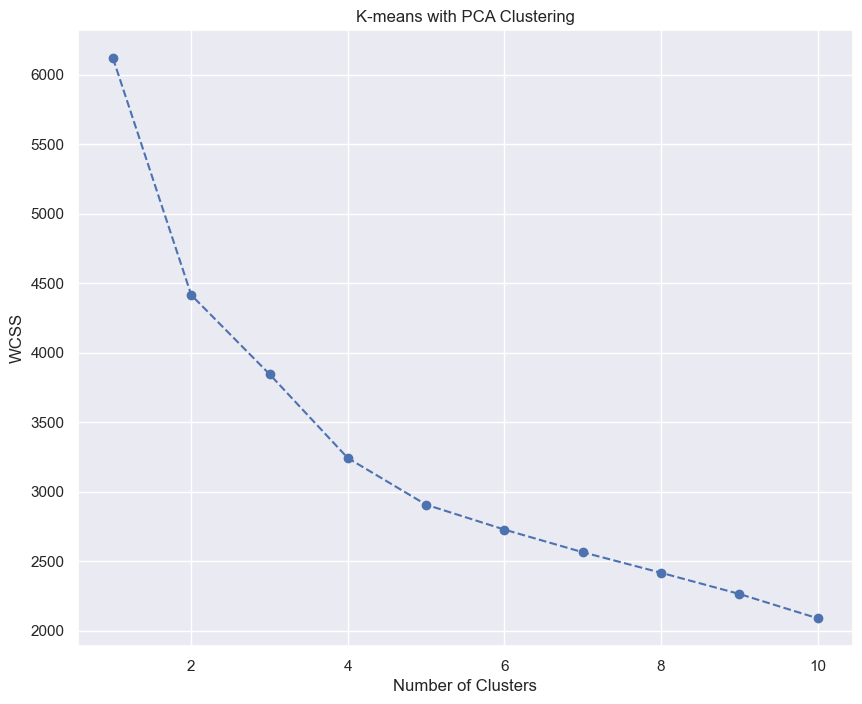

In [43]:
# Plot WCSS against the number of components on a graph

plt.figure(figsize = (10,8))
plt.plot(range(1,11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

### Observations: Decision to keep 4 clusters. This is where the line turns at the "elbow" and begins to flatten out.

## Implement K means using pca

Summary so far: decision to include 10 components and keep 4 clusters

In [44]:
# Choice to use 4 clusters

kmeans_pca = KMeans(n_clusters = 4, init='k-means++', random_state=42)

In [45]:
# Fit data with the k-means pca model

kmeans_pca.fit(scores_pca)

C:\Users\leobs\anaconda3\envs\Leoenvironment\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

# 05. Analyze results
- Visualize K-means results
- Plot clusters with variables
- Compare cluster stats

In [46]:
# Create new df with the original features and add the PCA scores and assigned clusters
df_song_segm_pca_kmeans = pd.concat([df_2.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_song_segm_pca_kmeans.columns.values[-10: ] = ['Component 1', 'Component 2', 'Component 3', 
                                                 'Component 4','Component 5', 'Component 6',
                                                 'Component 7','Component 8', 'Component 9',
                                                 'Component 10']

# Add the pca k-means clustering labels in the last column
df_song_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [47]:
df_song_segm_pca_kmeans.head()

,song_id,cnt_chart_wks,tot_streams,streams_n,speech,days,song_title,song_release_date,track,acou,dance,ener,instru,live,loud,temp,val,pop,dur,top_song,top_song_flag,album_id,album_title,w1_sales,last_stream_update,top_s_cnt,tv,alb_num,album_announce_mo,alb_ann_day,alb_ann_yr,album_announce_date,album_release_mo,alb_r_day,alb_r_yr,album_release_date,top_alb_count,top_alb_normal,alb_track_cnt,tvflag,sales_group,tot_streams_group,alb_genre,alb_cluster_num,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Segment K-means PCA
0,1989TV01,2.0,35521714,2732439,0.0327,13,Welcome To New York (Taylor's Version),10/27/2023,1,0.009420,0.757,0.610,0.000037,0.3670,-4.840,116.998,0.685,80,212600,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.673534,-2.702443,0.816780,2.797058,-0.050126,-0.382578,-0.092049,1.650973,-2.163858,-0.430902,1
1,1989TV02,3.0,40958068,3150620,0.0670,13,Blank Space (Taylor's Version),10/27/2023,2,0.088500,0.733,0.733,0.000000,0.1680,-5.376,96.057,0.701,80,231833,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.818839,-2.480086,0.943669,2.790250,-0.276518,-0.061074,-1.325902,0.423424,-1.372012,0.150480,1
2,1989TV03,4.0,47687102,3668238,0.0397,13,Style (Taylor's Version),10/27/2023,3,0.000421,0.511,0.822,0.019700,0.0899,-4.785,94.868,0.305,81,231000,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.943972,-2.024743,0.115567,2.418866,1.539801,-0.689616,-1.090074,0.627748,-0.686961,0.937360,1
3,1989TV04,3.0,37545128,2888086,0.0447,13,Out Of The Woods (Taylor's Version),10/27/2023,4,0.000537,0.545,0.885,0.000056,0.3850,-5.968,92.021,0.206,80,235800,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.812685,-2.336467,0.079379,2.507730,1.765034,-0.578483,1.079186,1.959083,-2.343652,-0.321903,1
4,1989TV05,2.0,31008534,2385271,0.0317,13,All You Had To Do Was Stay (Taylor's Version),10/27/2023,5,0.000656,0.588,0.721,0.000000,0.1310,-5.579,96.997,0.520,79,193289,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.870051,-2.098017,0.399118,2.584369,0.213875,-0.403520,-0.948680,0.460352,-1.013598,0.200901,1


In [48]:
df_song_segm_pca_kmeans['Segment K-means PCA'].value_counts(dropna=False)

Segment K-means PCA
1    96
2    75
3    70
0    41
Name: count, dtype: int64

In [49]:
df_song_segm_pca_kmeans.columns

Index(['song_id', 'cnt_chart_wks', 'tot_streams', 'streams_n', 'speech',
       'days', 'song_title', 'song_release_date', 'track', 'acou', 'dance',
       'ener', 'instru', 'live', 'loud', 'temp', 'val', 'pop', 'dur',
       'top_song', 'top_song_flag', 'album_id', 'album_title', 'w1_sales',
       'last_stream_update', 'top_s_cnt', 'tv', 'alb_num', 'album_announce_mo',
       'alb_ann_day', 'alb_ann_yr', 'album_announce_date', 'album_release_mo',
       'alb_r_day', 'alb_r_yr', 'album_release_date', 'top_alb_count',
       'top_alb_normal', 'alb_track_cnt', 'tvflag', 'sales_group',
       'tot_streams_group', 'alb_genre', 'alb_cluster_num', 'Component 1',
       'Component 2', 'Component 3', 'Component 4', 'Component 5',
       'Component 6', 'Component 7', 'Component 8', 'Component 9',
       'Component 10', 'Segment K-means PCA'],
      dtype='object')

In [50]:
# Create new column named cluster and map clusters inside it, with a clear label and numbers that >0

df_song_segm_pca_kmeans['song_cluster_num'] = df_song_segm_pca_kmeans['Segment K-means PCA'].map({0:1,
                                                    1: 2,
                                                    2: 3,
                                                    3: 4})

In [51]:
df_song_segm_pca_kmeans['song_cluster_num'].value_counts(dropna=False)

song_cluster_num
2    96
3    75
4    70
1    41
Name: count, dtype: int64

In [106]:
df_song_segm_pca_kmeans.head(20)

,song_id,cnt_chart_wks,tot_streams,streams_n,speech,days,song_title,song_release_date,track,acou,dance,ener,instru,live,loud,temp,val,pop,dur,top_song,top_song_flag,album_id,album_title,w1_sales,last_stream_update,top_s_cnt,tv,alb_num,album_announce_mo,alb_ann_day,alb_ann_yr,album_announce_date,album_release_mo,alb_r_day,alb_r_yr,album_release_date,top_alb_count,top_alb_normal,alb_track_cnt,tvflag,sales_group,tot_streams_group,alb_genre,alb_cluster_num,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Segment K-means PCA,song_cluster_num,song_cluster_color
0,1989TV01,2.0,35521714,2732439,0.0327,13,Welcome To New York (Taylor's Version),10/27/2023,1,0.009420,0.757,0.610,0.000037,0.3670,-4.840,116.998,0.6850,80,212600,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.673534,-2.702443,0.816780,2.797058,-0.050126,-0.382578,-0.092049,1.650973,-2.163858,-0.430902,1,2,yellow
1,1989TV02,3.0,40958068,3150620,0.0670,13,Blank Space (Taylor's Version),10/27/2023,2,0.088500,0.733,0.733,0.000000,0.1680,-5.376,96.057,0.7010,80,231833,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.818839,-2.480086,0.943669,2.790250,-0.276518,-0.061074,-1.325902,0.423424,-1.372012,0.150480,1,2,yellow
2,1989TV03,4.0,47687102,3668238,0.0397,13,Style (Taylor's Version),10/27/2023,3,0.000421,0.511,0.822,0.019700,0.0899,-4.785,94.868,0.3050,81,231000,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.943972,-2.024743,0.115567,2.418866,1.539801,-0.689616,-1.090074,0.627748,-0.686961,0.937360,1,2,yellow
3,1989TV04,3.0,37545128,2888086,0.0447,13,Out Of The Woods (Taylor's Version),10/27/2023,4,0.000537,0.545,0.885,0.000056,0.3850,-5.968,92.021,0.2060,80,235800,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.812685,-2.336467,0.079379,2.507730,1.765034,-0.578483,1.079186,1.959083,-2.343652,-0.321903,1,2,yellow
4,1989TV05,2.0,31008534,2385271,0.0317,13,All You Had To Do Was Stay (Taylor's Version),10/27/2023,5,0.000656,0.588,0.721,0.000000,0.1310,-5.579,96.997,0.5200,79,193289,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.870051,-2.098017,0.399118,2.584369,0.213875,-0.403520,-0.948680,0.460352,-1.013598,0.200901,1,2,yellow
5,1989TV06,2.0,29684734,2283441,0.0729,13,Shake It Off (Taylor's Version),10/27/2023,6,0.012100,0.636,0.808,0.000022,0.3590,-5.693,160.058,0.9170,79,219209,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.649689,-3.332966,0.549740,2.463739,-0.593843,-1.809998,0.181176,1.283443,-0.805152,-0.928987,1,2,yellow
6,1989TV07,1.0,27727454,2132881,0.0439,13,I Wish You Would (Taylor's Version),10/27/2023,7,0.003540,0.670,0.858,0.000013,0.0687,-6.528,118.009,0.5390,79,207650,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.909430,-2.307383,0.436582

## Visualize components

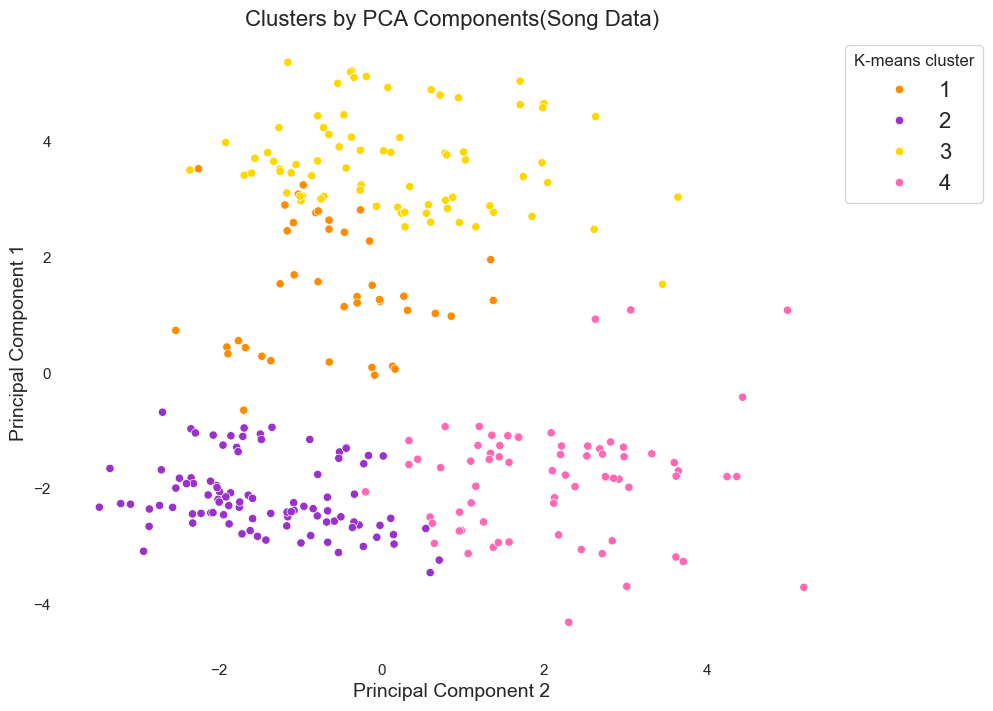

In [125]:
# Plot data by PCA components
# y-axis is first and x-axis is second

plt.figure(figsize = (10, 8))

song_pca_comp_clust_scatt = sns.scatterplot(data = df_song_segm_pca_kmeans, x='Component 2', y='Component 1', hue='song_cluster_num', hue_order=[1,2,3,4], palette=['darkorange','darkorchid', 'gold', 'hotpink'])

song_pca_comp_clust_scatt.grid(False)
song_pca_comp_clust_scatt.set_facecolor('#FFFFFF')
plt.title('Clusters by PCA Components(Song Data)', fontsize=16)
plt.xlabel('Principal Component 2', fontsize=14)
plt.ylabel('Principal Component 1', fontsize=14)
legend = plt.legend(bbox_to_anchor=(1.2, 1), title='K-means cluster', fontsize=16)
legend.get_frame().set_facecolor('white')

plt.show()


Observations: Clusters show relatively distinct groupings.

In [53]:
# Export viz

song_pca_comp_clust_scatt.figure.savefig(os.path.join(path, '03 Analysis', 'Visualizations', 'song_pca_comp_clust_scatt.png'))

## Plot the clusters for the variables

In [54]:
df_song_segm_pca_kmeans

,song_id,cnt_chart_wks,tot_streams,streams_n,speech,days,song_title,song_release_date,track,acou,dance,ener,instru,live,loud,temp,val,pop,dur,top_song,top_song_flag,album_id,album_title,w1_sales,last_stream_update,top_s_cnt,tv,alb_num,album_announce_mo,alb_ann_day,alb_ann_yr,album_announce_date,album_release_mo,alb_r_day,alb_r_yr,album_release_date,top_alb_count,top_alb_normal,alb_track_cnt,tvflag,sales_group,tot_streams_group,alb_genre,alb_cluster_num,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Segment K-means PCA,song_cluster_num
0,1989TV01,2.0,35521714,2732439,0.0327,13,Welcome To New York (Taylor's Version),10/27/2023,1,0.009420,0.757,0.610,0.000037,0.3670,-4.840,116.998,0.685,80,212600,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.673534,-2.702443,0.816780,2.797058,-0.050126,-0.382578,-0.092049,1.650973,-2.163858,-0.430902,1,2
1,1989TV02,3.0,40958068,3150620,0.0670,13,Blank Space (Taylor's Version),10/27/2023,2,0.088500,0.733,0.733,0.000000,0.1680,-5.376,96.057,0.701,80,231833,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.818839,-2.480086,0.943669,2.790250,-0.276518,-0.061074,-1.325902,0.423424,-1.372012,0.150480,1,2
2,1989TV03,4.0,47687102,3668238,0.0397,13,Style (Taylor's Version),10/27/2023,3,0.000421,0.511,0.822,0.019700,0.0899,-4.785,94.868,0.305,81,231000,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.943972,-2.024743,0.115567,2.418866,1.539801,-0.689616,-1.090074,0.627748,-0.686961,0.937360,1,2
3,1989TV04,3.0,37545128,2888086,0.0447,13,Out Of The Woods (Taylor's Version),10/27/2023,4,0.000537,0.545,0.885,0.000056,0.3850,-5.968,92.021,0.206,80,235800,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.812685,-2.336467,0.079379,2.507730,1.765034,-0.578483,1.079186,1.959083,-2.343652,-0.321903,1,2
4,1989TV05,2.0,31008534,2385271,0.0317,13,All You Had To Do Was Stay (Taylor's Version),10/27/2023,5,0.000656,0.588,0.721,0.000000,0.1310,-5.579,96.997,0.520,79,193289,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.870051,-2.098017,0.399118,2.584369,0.213875,-0.403520,-0.948680,0.460352,-1.013598,0.200901,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,DEBUT11,36.0,280561783,45070,0.0303,6225,Our Song,10/24/2006,11,0.111000,0.668,0.672,0.000000,0.3290,-4.931,89.011,0.539,77,201106,top song,True,DEBUT,Debut,39000,11/9/2023,5,original,1,June,19,2006,6/19/2006,October,24,2006,10/24/2006,284,0.045622,15,False,Low first week sales,High total streams,Country pop,3,5.129580,-0.184823,1.449344,-0.694378,0.077953,0.756247,-0.294581,1.865134,-1.010324,-1.814726,2,3
278,DEBUT12,0.0,43132276,6928,0.0646,6225,I'm Only Me When I'm With You,10/24/2006,12,0.004520,0.563,0.934,0.000807,0.1030,-3.629,143.964,0.518,62,213053,not top,False,DEBUT,Debut,39000,11/9/2023,5,original,1,June,19,2006,6/19/2006,October,24,2006,10/24/2006,284,0.045622,15,False,Low first week sales,Low total streams,C

### Add color column for ease of plotting

In [113]:
# Add color to df to match clusters
# 1 is purple, 2 is yellow, 3 is pink, 4 is orange

df_song_segm_pca_kmeans.loc[df_song_segm_pca_kmeans['song_cluster_num'] == 1, 'song_cluster_color'] = 'orange' 

In [124]:
df_song_segm_pca_kmeans.loc[df_song_segm_pca_kmeans['song_cluster_num'] == 2, 'song_cluster_color'] = 'purple' 

In [115]:
df_song_segm_pca_kmeans.loc[df_song_segm_pca_kmeans['song_cluster_num'] == 3, 'song_cluster_color'] = 'yellow' 

In [123]:
df_song_segm_pca_kmeans.loc[df_song_segm_pca_kmeans['song_cluster_num'] == 4, 'song_cluster_color'] = 'pink' 

In [117]:
df_song_segm_pca_kmeans['song_cluster_color'].value_counts(dropna=False)

song_cluster_color
pink      96
yellow    75
purple    70
orange    41
Name: count, dtype: int64

In [118]:
# Check values  of colors against values of cluster numbers

df_song_segm_pca_kmeans['song_cluster_num'].value_counts(dropna=False)

song_cluster_num
2    96
3    75
4    70
1    41
Name: count, dtype: int64

In [119]:
df_song_segm_pca_kmeans.head(25)

,song_id,cnt_chart_wks,tot_streams,streams_n,speech,days,song_title,song_release_date,track,acou,dance,ener,instru,live,loud,temp,val,pop,dur,top_song,top_song_flag,album_id,album_title,w1_sales,last_stream_update,top_s_cnt,tv,alb_num,album_announce_mo,alb_ann_day,alb_ann_yr,album_announce_date,album_release_mo,alb_r_day,alb_r_yr,album_release_date,top_alb_count,top_alb_normal,alb_track_cnt,tvflag,sales_group,tot_streams_group,alb_genre,alb_cluster_num,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Segment K-means PCA,song_cluster_num,song_cluster_color
0,1989TV01,2.0,35521714,2732439,0.0327,13,Welcome To New York (Taylor's Version),10/27/2023,1,0.009420,0.757,0.610,0.000037,0.3670,-4.840,116.998,0.6850,80,212600,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.673534,-2.702443,0.816780,2.797058,-0.050126,-0.382578,-0.092049,1.650973,-2.163858,-0.430902,1,2,pink
1,1989TV02,3.0,40958068,3150620,0.0670,13,Blank Space (Taylor's Version),10/27/2023,2,0.088500,0.733,0.733,0.000000,0.1680,-5.376,96.057,0.7010,80,231833,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.818839,-2.480086,0.943669,2.790250,-0.276518,-0.061074,-1.325902,0.423424,-1.372012,0.150480,1,2,pink
2,1989TV03,4.0,47687102,3668238,0.0397,13,Style (Taylor's Version),10/27/2023,3,0.000421,0.511,0.822,0.019700,0.0899,-4.785,94.868,0.3050,81,231000,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.943972,-2.024743,0.115567,2.418866,1.539801,-0.689616,-1.090074,0.627748,-0.686961,0.937360,1,2,pink
3,1989TV04,3.0,37545128,2888086,0.0447,13,Out Of The Woods (Taylor's Version),10/27/2023,4,0.000537,0.545,0.885,0.000056,0.3850,-5.968,92.021,0.2060,80,235800,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.812685,-2.336467,0.079379,2.507730,1.765034,-0.578483,1.079186,1.959083,-2.343652,-0.321903,1,2,pink
4,1989TV05,2.0,31008534,2385271,0.0317,13,All You Had To Do Was Stay (Taylor's Version),10/27/2023,5,0.000656,0.588,0.721,0.000000,0.1310,-5.579,96.997,0.5200,79,193289,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.870051,-2.098017,0.399118,2.584369,0.213875,-0.403520,-0.948680,0.460352,-1.013598,0.200901,1,2,pink
5,1989TV06,2.0,29684734,2283441,0.0729,13,Shake It Off (Taylor's Version),10/27/2023,6,0.012100,0.636,0.808,0.000022,0.3590,-5.693,160.058,0.9170,79,219209,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.649689,-3.332966,0.549740,2.463739,-0.593843,-1.809998,0.181176,1.283443,-0.805152,-0.928987,1,2,pink
6,1989TV07,1.0,27727454,2132881,0.0439,13,I Wish You Would (Taylor's Version),10/27/2023,7,0.003540,0.670,0.858,0.000013,0.0687,-6.528,118.009,0.5390,79,207650,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,11/9/2023,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,-1.909430,-2.307383,0.436582,2.627174,-0

### Scatterplots of original variable comparisons

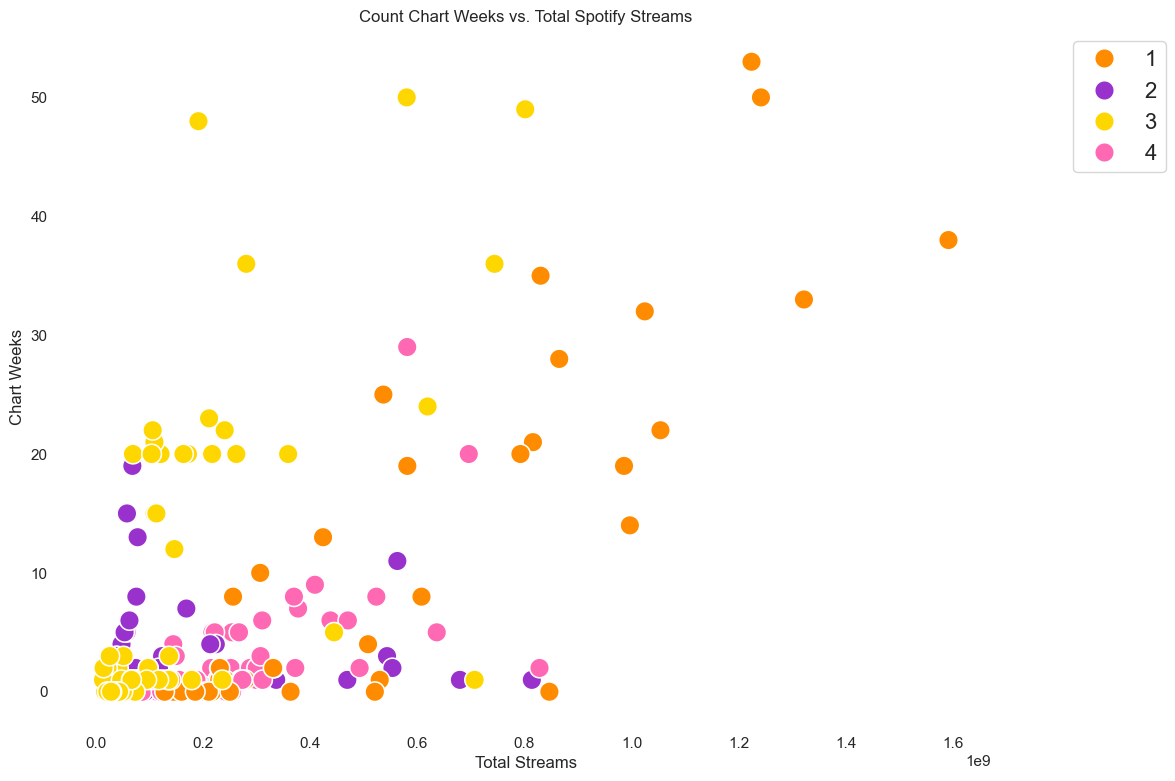

In [122]:
# Compare key variables while adding clusters to plot
# "Count Chart Weeks vs. Total Spotify Streams"

plt.figure(figsize = (12, 9))

tot_streams_cnt_chart_wks_scatt_clusters = sns.scatterplot(data = df_song_segm_pca_kmeans, x = 'tot_streams', y='cnt_chart_wks',
                                                               hue='song_cluster_num', hue_order=[1,2,3,4], 
                                                               palette=['darkorange','darkorchid', 'gold', 'hotpink'],
                                                               s=200)

tot_streams_cnt_chart_wks_scatt_clusters.grid(False)
tot_streams_cnt_chart_wks_scatt_clusters.set_facecolor('#FFFFFF')

plt.title("Count Chart Weeks vs. Total Spotify Streams")  
plt.xlabel("Total Streams")  
plt.ylabel("Chart Weeks")  
legend = plt.legend(bbox_to_anchor=(1.2, 1), fontsize=16)
legend.get_frame().set_facecolor('white')

plt.show()


Observations: Clustering is handy here.

- The orange cluster appears to have the strongest (linear) relationship between total streams and chart weeks.
- The yellow cluster has two clear groups in chart weeks as well as major chart outliers (high).
- The purple cluster has the most low streams songs with high number of chart weeks- likely showing recently released song hits.
- The pink cluster is spread throughout time, with low to medium chart weeks, and also appears to have a potentially linear relationship between variables.

In [62]:
# Export viz

tot_streams_cnt_chart_wks_scatt_clusters.figure.savefig(os.path.join(path, '03 Analysis', 'Visualizations', 'tot_streams_cnt_chart_wks_scatt_clusters.png'))

In [63]:
# Identify stats on chart weeks based on album cluster
# See which cluster has the most songs that never made the charts

not_top_songs = df_song_segm_pca_kmeans.loc[df_song_segm_pca_kmeans['cnt_chart_wks']== 0]

In [64]:
not_top_songs.shape

(68, 57)

In [65]:
not_top_songs['song_cluster_num'].value_counts(dropna=False)

song_cluster_num
3    26
2    18
1    13
4    11
Name: count, dtype: int64

This is very interesting, because the counts are spread for whether songs make the top charts.

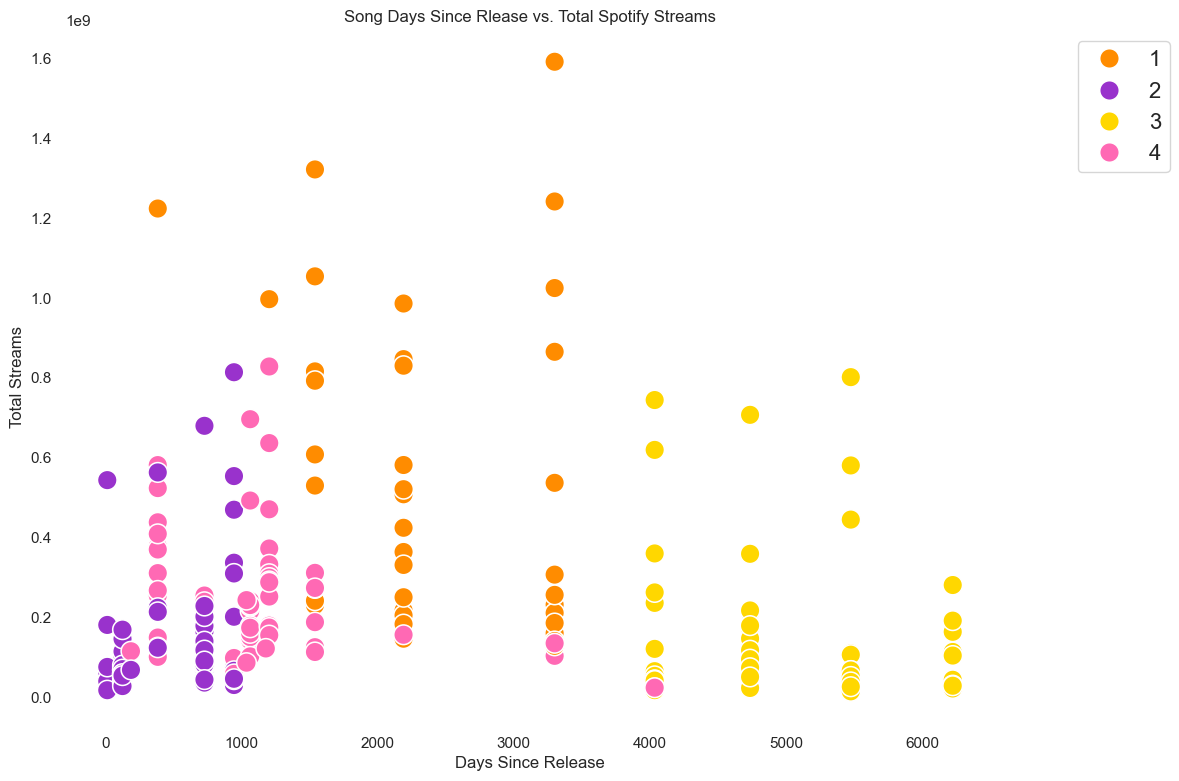

In [126]:
# Compare key variables while adding clusters to plot
# "Song Days Since Release vs. Total Spotify Streams"

plt.figure(figsize = (12, 9))

tot_streams_days_scatt_clusters = sns.scatterplot(data = df_song_segm_pca_kmeans, x = 'days', y='tot_streams',
                                                               hue='song_cluster_num', hue_order=[1,2,3,4], 
                                                               palette=['darkorange','darkorchid', 'gold', 'hotpink'],
                                                               s=200)

tot_streams_days_scatt_clusters.grid(False)
tot_streams_days_scatt_clusters.set_facecolor('#FFFFFF')

plt.title("Song Days Since Rlease vs. Total Spotify Streams")  
plt.xlabel("Days Since Release")  
plt.ylabel("Total Streams")  
legend = plt.legend(bbox_to_anchor=(1.2, 1), fontsize=16)
legend.get_frame().set_facecolor('white')

plt.show()

Observations: Clusters show patterns related to days since release. 
- Orange and pink clusters have the highest total streams even though they have the middle days since release. 
- The purple cluster has quite a few songs that outperform yellow (highest days since release) in total streams, showing that they are big hits. 
- The outliers of total streams for the yellow cluster shows songs that have maintained popularity over time. 

In [127]:
# Export viz

tot_streams_days_scatt_clusters.figure.savefig(os.path.join(path, '03 Analysis', 'Visualizations', 'tot_streams_days_scatt_clusters.png'))

In [68]:
df_song_segm_pca_kmeans.columns

Index(['song_id', 'cnt_chart_wks', 'tot_streams', 'streams_n', 'speech',
       'days', 'song_title', 'song_release_date', 'track', 'acou', 'dance',
       'ener', 'instru', 'live', 'loud', 'temp', 'val', 'pop', 'dur',
       'top_song', 'top_song_flag', 'album_id', 'album_title', 'w1_sales',
       'last_stream_update', 'top_s_cnt', 'tv', 'alb_num', 'album_announce_mo',
       'alb_ann_day', 'alb_ann_yr', 'album_announce_date', 'album_release_mo',
       'alb_r_day', 'alb_r_yr', 'album_release_date', 'top_alb_count',
       'top_alb_normal', 'alb_track_cnt', 'tvflag', 'sales_group',
       'tot_streams_group', 'alb_genre', 'alb_cluster_num', 'Component 1',
       'Component 2', 'Component 3', 'Component 4', 'Component 5',
       'Component 6', 'Component 7', 'Component 8', 'Component 9',
       'Component 10', 'Segment K-means PCA', 'song_cluster_num',
       'song_cluster_color'],
      dtype='object')

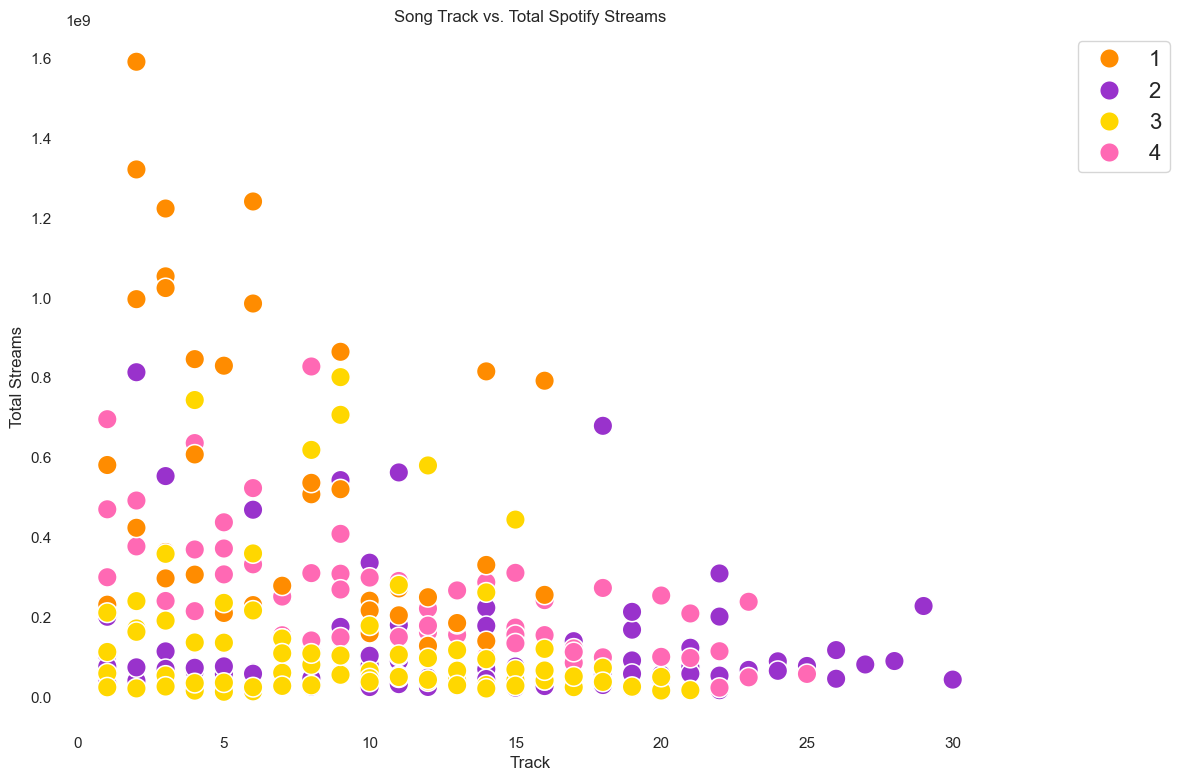

In [128]:
# Compare key variables while adding clusters to plot
# "Track vs. Total Spotify Streams"

plt.figure(figsize = (12, 9))

track_tot_streams_scatt_clusters = sns.scatterplot(data = df_song_segm_pca_kmeans, x = 'track', y='tot_streams',
                                                               hue='song_cluster_num', hue_order=[1,2,3,4], 
                                                               palette=['darkorange','darkorchid', 'gold', 'hotpink'],
                                                               s=200)

track_tot_streams_scatt_clusters.grid(False)
track_tot_streams_scatt_clusters.set_facecolor('#FFFFFF')

plt.title("Song Track vs. Total Spotify Streams")  
plt.xlabel("Track")  
plt.ylabel("Total Streams")  
legend = plt.legend(bbox_to_anchor=(1.2, 1), fontsize=16)
legend.get_frame().set_facecolor('white')

plt.show()


Observations: There is an overall downward pattern for all clusters- as track increases, total streams decrease.
- There is fairly even distribution across track number for the yellow cluster
- The orange cluster has the steepest drop in total streams as track increases (and highest overall total streams).

In [129]:
# Export viz

track_tot_streams_scatt_clusters.figure.savefig(os.path.join(path, '03 Analysis', 'Visualizations', 'track_tot_streams_scatt_clusters.png'))

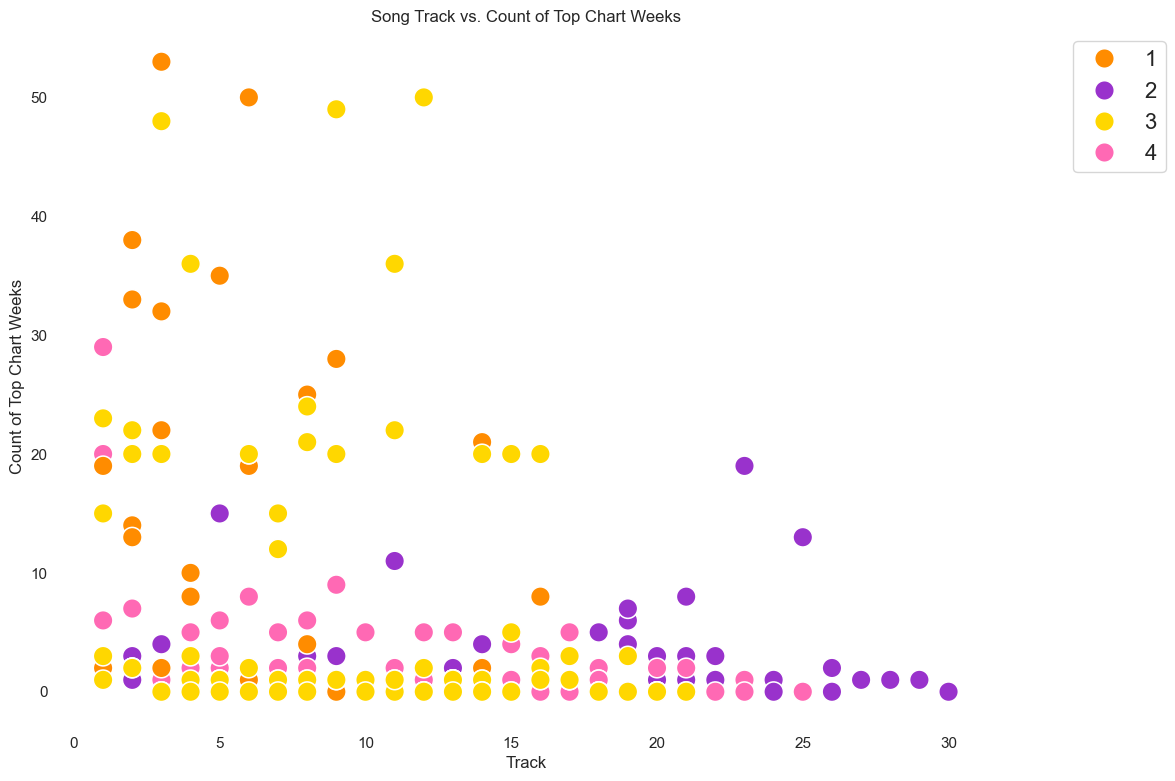

In [130]:
# Compare key variables while adding clusters to plot
# "Track vs. Count of Top Chart Weeks"

plt.figure(figsize = (12, 9))

track_cnt_char_wks_scatt_clusters = sns.scatterplot(data = df_song_segm_pca_kmeans, x = 'track', y='cnt_chart_wks',
                                                               hue='song_cluster_num', hue_order=[1,2,3,4], 
                                                               palette=['darkorange','darkorchid', 'gold', 'hotpink'],
                                                               s=200)

track_cnt_char_wks_scatt_clusters.grid(False)
track_cnt_char_wks_scatt_clusters.set_facecolor('#FFFFFF')

plt.title("Song Track vs. Count of Top Chart Weeks")  
plt.xlabel("Track")  
plt.ylabel("Count of Top Chart Weeks")  
legend = plt.legend(bbox_to_anchor=(1.2, 1), fontsize=16)
legend.get_frame().set_facecolor('white')

plt.show()


Observations:
- Orange and yellow clusters have the most tracks under 15 with chart weeks over 15
- Purple is the only cluster with tracks above 20 that make above 5 chart weeks. They likely include Taylor's Versions since vault tracks are at the end.


In [131]:
# Export viz

track_cnt_char_wks_scatt_clusters.figure.savefig(os.path.join(path, '03 Analysis', 'Visualizations', 'track_cnt_char_wks_scatt_clusters.png'))

### Explore other measures

In [132]:
# Crosstab of clusters and album number
# This will show me the album groupings for each cluster

song_clust_alb_crosstab = pd.crosstab(df_song_segm_pca_kmeans['album_id'], df_song_segm_pca_kmeans['song_cluster_color'], dropna=False)

In [133]:
song_clust_alb_crosstab

song_cluster_color,orange,pink,purple,yellow
album_id,,,,
1989,14,2,0,0
1989TV,0,1,21,0
DEBUT,0,0,0,15
EVER,0,17,0,0
FEAR,0,0,0,19
FEARTV,0,4,22,0
FOLK,2,15,0,0
LOVE,10,8,0,0
MIDN,1,17,5,0


Observations within each cluster:
- Orange has the highest total streams and includes 1989, REP, LOVE, and FOLK (in order)
- Yellow has the most time past with the least total streams: DEBUT, FEAR, RED, SPEAK
    -Mirrors similar patterns to album clusters
- Purple and pink have the least time past and middle total streams: 
    - Purple: 1989TV, FEARTV, REDTV, SPEAK TV
    -Purple includes all Taylor's Versions
    - Pink: EVER, MIDN, FOLK, LOVE, 1989, FEARTV, REDTV, REP

Observation within each album: Some albums are all within one cluster, while others are spread out. This helps show if there are specific songs that stand out within each album. I want to explore this aspect further.

## Return to original goals
- Are there cluster differences in the correlation between weeks on chart and total plays?
* shown above with scatter
- What are stats across clusters?- do they show what makes total plays vs. weeks on chart success?
   

In [134]:
# Set the display option to show all columns

pd.set_option('display.max_columns', None)

In [135]:
df_song_segm_pca_kmeans.columns

Index(['song_id', 'cnt_chart_wks', 'tot_streams', 'streams_n', 'speech',
       'days', 'song_title', 'song_release_date', 'track', 'acou', 'dance',
       'ener', 'instru', 'live', 'loud', 'temp', 'val', 'pop', 'dur',
       'top_song', 'top_song_flag', 'album_id', 'album_title', 'w1_sales',
       'last_stream_update', 'top_s_cnt', 'tv', 'alb_num', 'album_announce_mo',
       'alb_ann_day', 'alb_ann_yr', 'album_announce_date', 'album_release_mo',
       'alb_r_day', 'alb_r_yr', 'album_release_date', 'top_alb_count',
       'top_alb_normal', 'alb_track_cnt', 'tvflag', 'sales_group',
       'tot_streams_group', 'alb_genre', 'alb_cluster_num', 'Component 1',
       'Component 2', 'Component 3', 'Component 4', 'Component 5',
       'Component 6', 'Component 7', 'Component 8', 'Component 9',
       'Component 10', 'Segment K-means PCA', 'song_cluster_num',
       'song_cluster_color'],
      dtype='object')

In [140]:
# Focus on stats for key variables

song_kmeans_stats = df_song_segm_pca_kmeans.groupby(['song_cluster_num','song_cluster_color']).agg({
                                                         'cnt_chart_wks': ['min', 'mean', 'max'], 
                                                           'tot_streams':['min', 'mean', 'max'], 
                                                           'streams_n': ['min', 'mean', 'max'], 
                                                            'speech': ['min', 'mean', 'max'],
                                                           'days': ['min', 'mean', 'max'], 
                                                            'track': ['min', 'mean', 'max'], 
                                                            'acou': ['min', 'mean', 'max'], 
                                                            'dance': ['min', 'mean', 'max'], 
                                                            'w1_sales': ['min', 'mean', 'max'],
                                                           'alb_num':['min', 'mean', 'max'], 
                                                          'alb_cluster_num': ['min', 'mean', 'max']        
                                                             })

In [141]:
song_kmeans_stats

cnt_chart_wks                   \
                                              min       mean   max   
song_cluster_num song_cluster_color                                  
1                orange                       0.0  11.317073  53.0   
2                purple                       0.0   1.989583  19.0   
3                yellow                       0.0   7.946667  50.0   
4                pink                         0.0   2.785714  29.0   

                                    tot_streams                            \
                                            min          mean         max   
song_cluster_num song_cluster_color                                         
1                orange               128150753  5.383895e+08  1591542049   
2                purple                17075733  1.136719e+08   813690804   
3                yellow                13160501  1.322929e+08   801382039   
4                pink                  23321913  2.396163e+08   828060855   

                                    streams_n                          speech  \
                                          min          mean       max     min   
song_cluster_num song_cluster_color                                             
1                orange                 38833  3.244004e+05   3187018  0.0323   
2                purple                 31796  1.372881e+06  41797953  0.0250   
3                yellow                  2403  2.771867e+04    184388  0.0231   
4                pink                    5779  3.902947e+05   4397308  0.0256   

                                                       days               \
                                         mean     max   min         mean   
song_cluster_num song_cluster_color                                        
1                orange              0.078529  0.1960   384  2318.048780   
2                purple              0.044930  0.1940    13   462.666667   
3                yellow              0.034188  0.0916  4035  5024.986667   
4                pink                0.069604  0.5190    13  1060.028571   

                                          track                     acou  \
                                      max   min       mean max       min   
song_cluster_num song_cluster_color                                        
1                orange              3300     1   7.414634  16  0.000743   
2                purple               944     1  12.833333  30  0.000191   
3                yellow              6225     1  10.013333  21  0.000197   
4                pink                4035     1  11.671429  25  0.060900   

                                                      dance                   \
                                         mean    max    min      mean    max   
song_cluster_num song_cluster_color                                            
1                orange              0.108533  0.525  0.359  0.659000  0.897   
2                purple              0.125281  0.851  0.363  0.575000  0.800   
3                yellow              0.189153  0.852  0.371  0.580787  0.843   
4                pink                0.666524  0.971  0.292  0.571786  0.867   

                                    w1_sales                        alb_num  \
                                         min          mean      max     min   
song_cluster_num song_cluster_color                                           
1                orange               615000  1.081512e+06  1297000       5   
2                purple               179000  6.138021e+05  1359000      10   
3                yellow                39000  7.752893e+05  1208000       1   
4                pink                 154500  6.461786e+05  1359000       4   

                                                   alb_cluster_num           
                                          mean max             min mean max  
song_cluster_num song_cluster_color                                          
1                orang

In [142]:
# Remove component columns for ease of use and data export

df_updated = df_song_segm_pca_kmeans[['song_id', 'cnt_chart_wks', 'tot_streams', 'streams_n', 
                           'song_cluster_num', 'song_cluster_color',
                           'speech', 'days', 'song_title', 'song_release_date', 'track', 'acou', 'dance',
                           'ener', 'instru', 'live', 'loud', 'temp', 'val', 'pop', 'dur',
                           'top_song', 'top_song_flag', 
                           'album_id', 'album_title', 'w1_sales', 'top_s_cnt', 'tv', 'alb_num', 'album_announce_mo',
                           'alb_ann_day', 'alb_ann_yr', 'album_announce_date', 'album_release_mo',
                           'alb_r_day', 'alb_r_yr', 'album_release_date', 'top_alb_count',
                           'top_alb_normal', 'alb_track_cnt', 'tvflag', 'sales_group',
                           'tot_streams_group', 'alb_genre', 'alb_cluster_num', 'last_stream_update', 
                           ]]

In [143]:
df_updated.shape

(282, 46)

In [144]:
df_updated.head(10)

,song_id,cnt_chart_wks,tot_streams,streams_n,song_cluster_num,song_cluster_color,speech,days,song_title,song_release_date,track,acou,dance,ener,instru,live,loud,temp,val,pop,dur,top_song,top_song_flag,album_id,album_title,w1_sales,top_s_cnt,tv,alb_num,album_announce_mo,alb_ann_day,alb_ann_yr,album_announce_date,album_release_mo,alb_r_day,alb_r_yr,album_release_date,top_alb_count,top_alb_normal,alb_track_cnt,tvflag,sales_group,tot_streams_group,alb_genre,alb_cluster_num,last_stream_update
0,1989TV01,2.0,35521714,2732439,2,purple,0.0327,13,Welcome To New York (Taylor's Version),10/27/2023,1,0.009420,0.757,0.610,0.000037,0.3670,-4.840,116.998,0.685,80,212600,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,11/9/2023
1,1989TV02,3.0,40958068,3150620,2,purple,0.0670,13,Blank Space (Taylor's Version),10/27/2023,2,0.088500,0.733,0.733,0.000000,0.1680,-5.376,96.057,0.701,80,231833,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,11/9/2023
2,1989TV03,4.0,47687102,3668238,2,purple,0.0397,13,Style (Taylor's Version),10/27/2023,3,0.000421,0.511,0.822,0.019700,0.0899,-4.785,94.868,0.305,81,231000,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,11/9/2023
3,1989TV04,3.0,37545128,2888086,2,purple,0.0447,13,Out Of The Woods (Taylor's Version),10/27/2023,4,0.000537,0.545,0.885,0.000056,0.3850,-5.968,92.021,0.206,80,235800,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,11/9/2023
4,1989TV05,2.0,31008534,2385271,2,purple,0.0317,13,All You Had To Do Was Stay (Taylor's Version),10/27/2023,5,0.000656,0.588,0.721,0.000000,0.1310,-5.579,96.997,0.520,79,193289,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,11/9/2023
5,1989TV06,2.0,29684734,2283441,2,purple,0.0729,13,Shake It Off (Taylor's Version),10/27/2023,6,0.012100,0.636,0.808,0.000022,0.3590,-5.693,160.058,0.917,79,219209,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,11/9/2023
6,1989TV07,1.0,27727454,2132881,2,purple,0.0439,13,I Wish You Would (Taylor's Version),10/27/2023,7,0.003540,0.670,0.858,0.000013,0.0687,-6.528,118.009,0.539,79,207650,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,11/9/2023
7,1989TV08,3.0,26353077,2027159,2,purple,0.1940,13,Bad Blood (Taylor's Version),10/27/2023,8,0.036200,0.618,0.683,0.000000,0.3050,-6.438,169.971,0.363,78,211103,top song,False,1989TV,1989 (Taylor's Version)[Deluxe],1359000,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,Low total streams,Synth/Dream/Dance pop,2,11/9/2023
8,1989TV09,3.0,543373389,41797953,2,purple,0.0656,13,Wildest Dreams (Taylor's Version),10/27/2023,9,0.043600,0.589,0.674,0.000072,0.1120,-7.480,139.985,0.514,78,220433,top song,True,1989TV,1989 (Taylor's Version)[Deluxe],1359000,21,Taylor's Version,14,August,9,2023,8/9/2023,October,27,2023,10/27/2023,1,0.076923,22,True,High first week sales,High total streams,Sy

In [145]:
df_updated.tail(10)

,song_id,cnt_chart_wks,tot_streams,streams_n,song_cluster_num,song_cluster_color,speech,days,song_title,song_release_date,track,acou,dance,ener,instru,live,loud,temp,val,pop,dur,top_song,top_song_flag,album_id,album_title,w1_sales,top_s_cnt,tv,alb_num,album_announce_mo,alb_ann_day,alb_ann_yr,album_announce_date,album_release_mo,alb_r_day,alb_r_yr,album_release_date,top_alb_count,top_alb_normal,alb_track_cnt,tvflag,sales_group,tot_streams_group,alb_genre,alb_cluster_num,last_stream_update
272,DEBUT06,0.0,24615529,3954,3,yellow,0.0293,6225,The Outside,10/24/2006,6,0.00491,0.589,0.805,0.000000,0.2400,-4.055,112.982,0.591,58,207106,not top,False,DEBUT,Debut,39000,5,original,1,June,19,2006,6/19/2006,October,24,2006,10/24/2006,284,0.045622,15,False,Low first week sales,Low total streams,Country pop,3,11/9/2023
273,DEBUT07,0.0,27809046,4467,3,yellow,0.0294,6225,Tied Together with a Smile,10/24/2006,7,0.52500,0.479,0.578,0.000000,0.0841,-4.963,146.165,0.192,59,248106,not top,False,DEBUT,Debut,39000,5,original,1,June,19,2006,6/19/2006,October,24,2006,10/24/2006,284,0.045622,15,False,Low first week sales,Low total streams,Country pop,3,11/9/2023
274,DEBUT08,0.0,29504431,4739,3,yellow,0.0246,6225,Stay Beautiful,10/24/2006,8,0.08680,0.594,0.629,0.000000,0.1370,-4.919,131.597,0.504,59,236053,not top,False,DEBUT,Debut,39000,5,original,1,June,19,2006,6/19/2006,October,24,2006,10/24/2006,284,0.045622,15,False,Low first week sales,Low total streams,Country pop,3,11/9/2023
275,DEBUT09,20.0,103848381,16682,3,yellow,0.0289,6225,Should've Said No,10/24/2006,9,0.01030,0.476,0.777,0.000000,0.1960,-3.771,167.964,0.472,69,242200,top song,True,DEBUT,Debut,39000,5,original,1,June,19,2006,6/19/2006,October,24,2006,10/24/2006,284,0.045622,15,False,Low first week sales,Medium total streams,Country pop,3,11/9/2023
276,DEBUT10,0.0,37893761,6087,3,yellow,0.0292,6225,Mary's Song (Oh My My My),10/24/2006,10,0.01770,0.403,0.627,0.000000,0.1820,-5.280,74.900,0.374,62,213080,not top,False,DEBUT,Debut,39000,5,original,1,June,19,2006,6/19/2006,October,24,2006,10/24/2006,284,0.045622,15,False,Low first week sales,Low total streams,Country pop,3,11/9/2023
277,DEBUT11,36.0,280561783,45070,3,yellow,0.0303,6225,Our Song,10/24/2006,11,0.11100,0.668,0.672,0.000000,0.3290,-4.931,89.011,0.539,77,201106,top song,True,DEBUT,Debut,39000,5,original,1,June,19,2006,6/19/2006,October,24,2006,10/24/2006,284,0.045622,15,False,Low first week sales,High total streams,Country pop,3,11/9/2023
278,DEBUT12,0.0,43132276,6928,3,yellow,0.0646,6225,I'm Only Me When I'm With You,10/24/2006,12,0.00452,0.563,0.934,0.000807,0.1030,-3.629,143.964,0.518,62,213053,not top,False,DEBUT,Debut,39000,5,original,1,June,19,2006,6/19/2006,October,24,2006,10/24/2006,284,0.045622,15,False,Low first week sales,Low total streams,Country pop,3,11/9/2023
279,DEBUT13,0.0,29681361,4768,3,yellow,0.0243,6225,Invisible,10/24/2006,13,0.63700,0.612,0.394,0.000000,0.1470,-5.723,96.001,0.233,58,203226,not top,False,DEBUT,Debut,39000,5,original,1,June,19,2006,6/19/2006,October,24,2006,10/24/2006,284,0.045622,15,False,Low first week sales,Low total streams,Country pop,3,11/9/2023
280,DEBUT14,0.0,21365584,3432,3,yellow,0.0365,6225,A Perfectly Good Heart,10/24/2006,14,0.00349,0.483,0.751,0.000000,0.1280,-5.726,156.092,0.268,57,220146,not top,False,DEBUT,Debut,39000,5,original,1,June,19,2006,6/19/2006,October,24,2006,10/24/2006,284,0.045622,15,False,Low first week sales,Low total streams,Country pop,3,11/9/2023
281,DEBUT15,0.0,28224285,4534,3,yellow,0.0537,6225,Teardrops on My Guitar - Pop Version,10/24/2006,15,0.04020,0.459,0.753,0.000000,0.0863,-3.827,199.997,0.483,57,179066,not top,False,DEBUT,Debut,39000,5,original,1,June,19,2006,6/19/2006,October,24,2006,10/24/2006,284,0.045622,15,False,Low first week sales,Low total streams,Country pop,3,11/9/2023


# 06. Update song clusters on relevant dfs
- Billboard Hot 100

In [146]:
# Review billboard data

bill.head()

,chart_week,chart_position,song_title,artist,prior_wk_position,peak_pos,wks_on_chart,album_title,song_release_date,track,acou,dance,ener,instru,live,loud,speech,temp,val,pop,dur,album_id,song_id,days,tot_streams,last_stream_update,streams_n,top_song,top_song_flag,top_s_cnt,tv,alb_num,album_announce_mo,alb_ann_day,alb_ann_yr,album_announce_date,album_release_mo,alb_r_day,alb_r_yr,album_release_date,w1_sales,top_alb_count,top_alb_normal,alb_track_cnt,tvflag,sales_group,tot_streams_group,alb_genre
884.0,7/27/2013,65.0,22,Taylor Swift,55.0,20.0,20.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,22.0,2012.0,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock
885.0,7/20/2013,55.0,22,Taylor Swift,49.0,20.0,19.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,22.0,2012.0,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock
886.0,7/13/2013,49.0,22,Taylor Swift,41.0,20.0,18.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,22.0,2012.0,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock
887.0,7/6/2013,41.0,22,Taylor Swift,32.0,20.0,17.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,22.0,2012.0,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock
889.0,6/29/2013,32.0,22,Taylor Swift,26.0,20.0,16.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,22.0,2012.0,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock


In [147]:
bill.shape

(1446, 48)

In [148]:
bill.columns

Index(['chart_week', 'chart_position', 'song_title', 'artist',
       'prior_wk_position', 'peak_pos', 'wks_on_chart', 'album_title',
       'song_release_date', 'track', 'acou', 'dance', 'ener', 'instru', 'live',
       'loud', 'speech', 'temp', 'val', 'pop', 'dur', 'album_id', 'song_id',
       'days', 'tot_streams', 'last_stream_update', 'streams_n', 'top_song',
       'top_song_flag', 'top_s_cnt', 'tv', 'alb_num', 'album_announce_mo',
       'alb_ann_day', 'alb_ann_yr', 'album_announce_date', 'album_release_mo',
       'alb_r_day', 'alb_r_yr', 'album_release_date', 'w1_sales',
       'top_alb_count', 'top_alb_normal', 'alb_track_cnt', 'tvflag',
       'sales_group', 'tot_streams_group', 'alb_genre'],
      dtype='object')

In [149]:
# Remove merge flag

bill.drop(columns = ['_merge'], axis=1, inplace=True)

KeyError: "['_merge'] not found in axis"

In [ ]:
df_song_segm_pca_kmeans.columns

In [150]:
bill.isnull().sum()

chart_week             0
chart_position         0
song_title             0
artist                 0
prior_wk_position      0
peak_pos               0
wks_on_chart           0
album_title            0
song_release_date      0
track                  0
acou                   0
dance                  0
ener                   0
instru                 0
live                   0
loud                   0
speech                 0
temp                   0
val                    0
pop                    0
dur                    0
album_id               0
song_id                0
days                   0
tot_streams            0
last_stream_update     0
streams_n              0
top_song               0
top_song_flag          0
top_s_cnt              0
tv                     0
alb_num                0
album_announce_mo      0
alb_ann_day            0
alb_ann_yr             0
album_announce_date    0
album_release_mo       0
alb_r_day              0
alb_r_yr               0
album_release_date     0


In [151]:
# Create subset of songs df to merge into billboard df

song_cluster_df = df_song_segm_pca_kmeans[['song_id', 'song_cluster_num','song_cluster_color']]

In [152]:
song_cluster_df.head()

,song_id,song_cluster_num,song_cluster_color
0,1989TV01,2,purple
1,1989TV02,2,purple
2,1989TV03,2,purple
3,1989TV04,2,purple
4,1989TV05,2,purple


In [153]:
song_cluster_df.shape

(282, 3)

In [154]:
song_cluster_df.tail(20)

,song_id,song_cluster_num,song_cluster_color
262,FEAR15,3,yellow
263,FEAR16,3,yellow
264,FEAR17,3,yellow
265,FEAR18,3,yellow
266,FEAR19,3,yellow
267,DEBUT01,3,yellow
268,DEBUT02,3,yellow
269,DEBUT03,3,yellow
270,DEBUT04,3,yellow
271,DEBUT05,3,yellow


In [155]:
bill.shape

(1446, 48)

In [156]:
# Use song_id as merge to add song cluster number and color onto billboard df to use for time series analysis

bill_clust = bill.merge(song_cluster_df, on = 'song_id', how='left', indicator=True)

In [157]:
bill_clust.shape

(1446, 51)

In [158]:
bill_clust.head(10)

,chart_week,chart_position,song_title,artist,prior_wk_position,peak_pos,wks_on_chart,album_title,song_release_date,track,acou,dance,ener,instru,live,loud,speech,temp,val,pop,dur,album_id,song_id,days,tot_streams,last_stream_update,streams_n,top_song,top_song_flag,top_s_cnt,tv,alb_num,album_announce_mo,alb_ann_day,alb_ann_yr,album_announce_date,album_release_mo,alb_r_day,alb_r_yr,album_release_date,w1_sales,top_alb_count,top_alb_normal,alb_track_cnt,tvflag,sales_group,tot_streams_group,alb_genre,song_cluster_num,song_cluster_color,_merge
0,7/27/2013,65.0,22,Taylor Swift,55.0,20.0,20.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,22.0,2012.0,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,3,yellow,both
1,7/20/2013,55.0,22,Taylor Swift,49.0,20.0,19.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,22.0,2012.0,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,3,yellow,both
2,7/13/2013,49.0,22,Taylor Swift,41.0,20.0,18.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,22.0,2012.0,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,3,yellow,both
3,7/6/2013,41.0,22,Taylor Swift,32.0,20.0,17.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,22.0,2012.0,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,3,yellow,both
4,6/29/2013,32.0,22,Taylor Swift,26.0,20.0,16.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,22.0,2012.0,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,3,yellow,both
5,6/22/2013,26.0,22,Taylor Swift,24.0,20.0,15.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,22.0,2012.0,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,3,yellow,both
6,6/15/2013,24.0,22,Taylor Swift,23.0,20.0,14.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,22.0,2012.0,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,3,yellow,both
7,6/8/2013,23.0,22,Taylor Swift,26.0,20.0,13.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,22.0,2012.0,10/22/2012,1208000.0,185.0,0.045849,22.0,False,High first week sales,High total streams,Pop rock,3,yellow,both
8,6/1/2013,26.0,22,Taylor Swift,25.0,20.0,12.0,Red (Deluxe Edition),10/22/2012,6.0,0.00215,0.658,0.729,0.0013,0.0752,-6.561,0.0378,104.007,0.668,60.0,230133.0,RED,RED06,4035.0,359657667.0,11/9/2023,89134.0,top song,True,4.0,original,4.0,August,13.0,2012.0,8/13/2012,October,2

In [159]:
bill_clust['_merge'].value_counts(dropna=False)

_merge
both          1446
left_only        0
right_only       0
Name: count, dtype: int64

In [160]:
bill_clust['song_cluster_color'].value_counts(dropna=False)

song_cluster_color
yellow    596
orange    464
pink      195
purple    191
Name: count, dtype: int64

# 07. Key observations and next steps

In [161]:
song_kmeans_stats

cnt_chart_wks                   \
                                              min       mean   max   
song_cluster_num song_cluster_color                                  
1                orange                       0.0  11.317073  53.0   
2                purple                       0.0   1.989583  19.0   
3                yellow                       0.0   7.946667  50.0   
4                pink                         0.0   2.785714  29.0   

                                    tot_streams                            \
                                            min          mean         max   
song_cluster_num song_cluster_color                                         
1                orange               128150753  5.383895e+08  1591542049   
2                purple                17075733  1.136719e+08   813690804   
3                yellow                13160501  1.322929e+08   801382039   
4                pink                  23321913  2.396163e+08   828060855   

                                    streams_n                          speech  \
                                          min          mean       max     min   
song_cluster_num song_cluster_color                                             
1                orange                 38833  3.244004e+05   3187018  0.0323   
2                purple                 31796  1.372881e+06  41797953  0.0250   
3                yellow                  2403  2.771867e+04    184388  0.0231   
4                pink                    5779  3.902947e+05   4397308  0.0256   

                                                       days               \
                                         mean     max   min         mean   
song_cluster_num song_cluster_color                                        
1                orange              0.078529  0.1960   384  2318.048780   
2                purple              0.044930  0.1940    13   462.666667   
3                yellow              0.034188  0.0916  4035  5024.986667   
4                pink                0.069604  0.5190    13  1060.028571   

                                          track                     acou  \
                                      max   min       mean max       min   
song_cluster_num song_cluster_color                                        
1                orange              3300     1   7.414634  16  0.000743   
2                purple               944     1  12.833333  30  0.000191   
3                yellow              6225     1  10.013333  21  0.000197   
4                pink                4035     1  11.671429  25  0.060900   

                                                      dance                   \
                                         mean    max    min      mean    max   
song_cluster_num song_cluster_color                                            
1                orange              0.108533  0.525  0.359  0.659000  0.897   
2                purple              0.125281  0.851  0.363  0.575000  0.800   
3                yellow              0.189153  0.852  0.371  0.580787  0.843   
4                pink                0.666524  0.971  0.292  0.571786  0.867   

                                    w1_sales                        alb_num  \
                                         min          mean      max     min   
song_cluster_num song_cluster_color                                           
1                orange               615000  1.081512e+06  1297000       5   
2                purple               179000  6.138021e+05  1359000      10   
3                yellow                39000  7.752893e+05  1208000       1   
4                pink                 154500  6.461786e+05  1359000       4   

                                                   alb_cluster_num           
                                          mean max             min mean max  
song_cluster_num song_cluster_color                                          
1                orang

### "Count Chart Weeks vs. Total Spotify Streams"- key focus

#### Observations
- The orange cluster appears to have the strongest (potentially linear) relationship between total streams and chart weeks.
- The yellow cluster has two clear groups in chart weeks as well as major chart outliers (high).
- The purple cluster has the most low streams songs with high number of chart weeks- likely showing recently released song hits.
- The pink cluster is spread throughout time, with low to medium chart weeks, and also appears to have a potentially linear relationship between variables.

### Orange Cluster (1) Songs
- Middle to late albumbs 
- Highest avg number of chart weeks
- Highest avg total streams
- WAY higher maximum total streams
- Middle avg daily streams
- 2nd speechiness
- Lowest average track number
- Highest danceability average
- Highest week 1 album sales by far

### Purple Cluster (2) Songs
- Later albums/newest
- Low/medium chart weeks (time is a factor)
- Lowest avg total streams
- Highest average daily streams (TV- newer!)
- Lower speechiness
- Highest avg track number

### Yellow Cluster (3) Songs
- Earliest albums (1-4, oldest)
- 2nd highest chart weeks (time as factor)
- 3rd average total streams (even though longest time since release)
- Lowest avg daily streams
- Lower speechiness
- Lowest week 1 sales

### Pink Cluster (4) Songs
- middle career/wide spread (4-14 range) albums
- low to medium avg chart weeks
- 2nd highest avg total streams
- Highest avg speechiness 
- Accoustic stand out top (major- 0.68 avg accou vs. .1 others)
- Medium week 1 sales



## Next Step: 
1. #### Explore cluster patterns between total streams and chart weeks (0.635 corr) as well as between categorical and non-continuous variables in Tableau
- album number
- Taylor's Version
- track

2. #### Attempt to identify why there are two distinct groups of the yellow cluster in terms of count of top chart weeks

3. #### Look into overlap between song clusters and album clustering, use this to identify stand out songs 

4. #### Highlight qualities that stand out:
  - For orange cluster (highest streams and song chart weeks & wk1 album sales): danceability
  - For pink cluster (lowest total streams and chart weeks): accousticsness

# 08. Data export

In [162]:
# Export dataframe used for clustering for reference
# Includes new song clusters

df_song_segm_pca_kmeans.to_csv(os.path.join(path, '02 Manipulated Data', 'df_song_segm_pca_kmeans.csv'))

In [163]:
# Export stats for song k-means clusters

song_kmeans_stats.to_csv(os.path.join(path, '02 Manipulated Data', 'song_kmeans_stats.csv'))

In [164]:
# Export updated billboard dataframe that includes clusters

bill_clust.to_csv(os.path.join(path, '02 Manipulated Data', 'df_hot_100_ts_only_dec_23_clust.csv'))

In [165]:
# Update song stream dataframe using df with clusters added and component columns removed

df_updated.to_csv(os.path.join(path, '02 Manipulated Data', 'song_stream_alb_final_5_clust.csv'))